In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing Data

In [2]:
df = pd.read_csv('zillow_data.csv')
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head()

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Focusing on homes in Arizona

In [3]:
df = df[df['State']=='AZ']

In [4]:
df = df[(df['Metro'] == 'Phoenix')]

df = df[(df['zipcode'] == 85253)|(df['zipcode'] == 85262)|
(df['zipcode'] == 85377)| (df['zipcode'] == 85255)|(df['zipcode'] == 85266)|
                             (df['zipcode'] == 85259)|(df['zipcode'] == 85258)|
                             (df['zipcode'] == 85018)|(df['zipcode'] == 85263)|
                             (df['zipcode'] == 85054)]

Number of Unique Zipcodes in Arizona: 230

In [5]:
df['zipcode'].value_counts().sum()

10

# Reshaping Data

In [6]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['zipcode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
melted = melt_data(df)
melted = melted.set_index('time')
melted.shape

(2650, 8)

In [8]:
melted = melted['2009-04-01':'2018-04-01']

### Grouping By zipcode

In [9]:
grouped = melted.groupby(['zipcode','time']).aggregate({'value':'mean'})
grouped

value
zipcode time                
85018   2009-04-01  397600.0
        2009-05-01  392500.0
        2009-06-01  386800.0
        2009-07-01  381300.0
        2009-08-01  376200.0
...                      ...
85377   2017-12-01  865500.0
        2018-01-01  864700.0
        2018-02-01  863200.0
        2018-03-01  859600.0
        2018-04-01  854900.0

[1090 rows x 1 columns]

In [10]:
grouped.loc[85018]

,value
time,
2009-04-01,397600.0
2009-05-01,392500.0
2009-06-01,386800.0
2009-07-01,381300.0
2009-08-01,376200.0
...,...
2017-12-01,621700.0
2018-01-01,629600.0
2018-02-01,636000.0


### Resampling to Monthly

In [11]:
resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)
resampled

RegionID  SizeRank     value
zipcode time                                    
85018   2009-04-01     94734      1075  397600.0
        2009-05-01     94734      1075  392500.0
        2009-06-01     94734      1075  386800.0
        2009-07-01     94734      1075  381300.0
        2009-08-01     94734      1075  376200.0
...                      ...       ...       ...
85377   2017-12-01     94951     11251  865500.0
        2018-01-01     94951     11251  864700.0
        2018-02-01     94951     11251  863200.0
        2018-03-01     94951     11251  859600.0
        2018-04-01     94951     11251  854900.0

[1090 rows x 3 columns]

In [12]:
# # melted df
# melted = melt_data(df)
# melted = melted.set_index('time')
# melted = melted['2009-04-01':'2018-04-01']

# #groupby zipcode
# grouped = melted.groupby(['zipcode','time','growth']).aggregate({'value':'mean'})

# # resampled df to monthly freq
# resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)

### Adding ZHVI forecasted monthly growth column

In [13]:
# melted df
melted = melt_data(df)
melted = melted.set_index('time')
melted = melted['2009-04-01':'2018-04-01']

#groupby zipcode
grouped = melted.groupby(['zipcode','time']).aggregate({'value':'mean'})

# resampled df
resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)

###############
# Growth Calculation
###############

# shift by one period (month)
resampled_shift_1 = resampled[['value']].shift(1)
resampled_shift_1.bfill(inplace=True)

# reset the indexes to perform calculation of growth
resampled = resampled.reset_index()
resampled_shift_1 = resampled_shift_1.reset_index()

# Growth Calculation
resampled['growth'] = (resampled['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])

# set the index back to zipcode and time multi-index
resampled.set_index(['zipcode','time'],inplace=True)

In [14]:
resampled =  resampled[['growth','value']]
resampled

growth     value
zipcode time                          
85018   2009-04-01  0.000000  397600.0
        2009-05-01 -0.012827  392500.0
        2009-06-01 -0.014522  386800.0
        2009-07-01 -0.014219  381300.0
        2009-08-01 -0.013375  376200.0
...                      ...       ...
85377   2017-12-01  0.000231  865500.0
        2018-01-01 -0.000924  864700.0
        2018-02-01 -0.001735  863200.0
        2018-03-01 -0.004171  859600.0
        2018-04-01 -0.005468  854900.0

[1090 rows x 2 columns]

In [15]:
(392500-397600)/397600

-0.012826961770623743

# EDA

### Plotting zipcode series

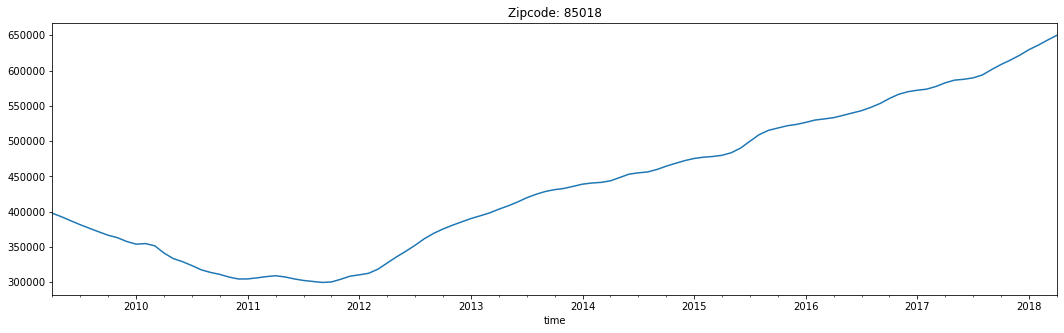

In [16]:
def plot_zip(zipcode,column):
    series = resampled.loc[zipcode,column]
    fig, ax = plt.subplots(figsize=(18,5))
    series.plot(ax=ax)
    ax.set_title("Zipcode: "+ str(zipcode));
    
plot_zip(85018,'value')

In [17]:
def stationarity_check(TS):
    dftest = adfuller(TS)
    
    
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [18]:
stationarity_check(resampled.loc[85018,'value'])

Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


### Looking at Value stationarity

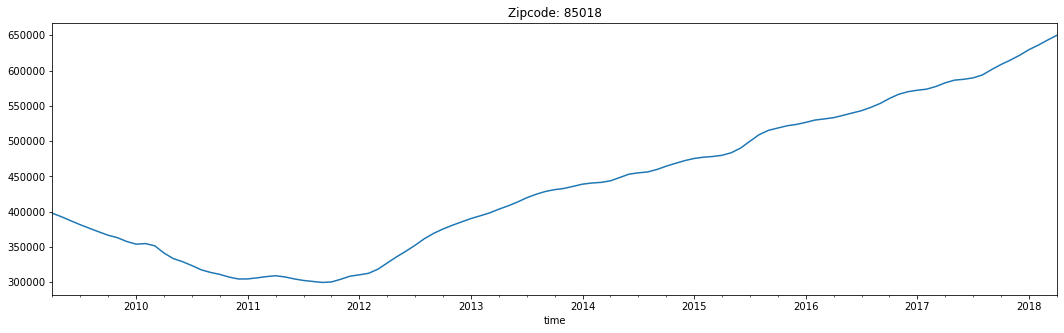

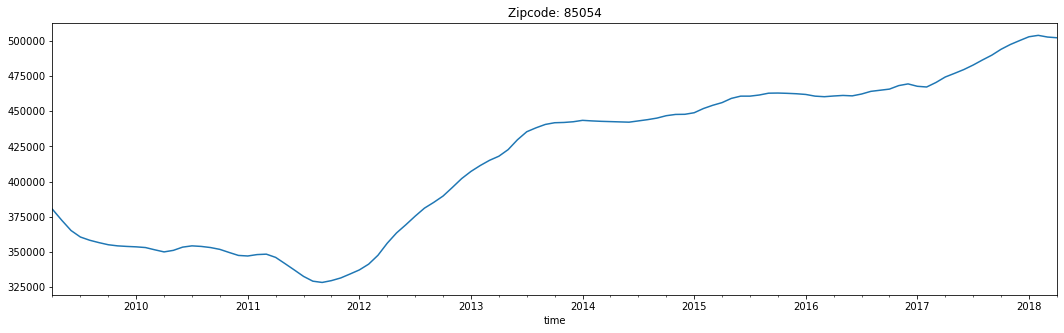

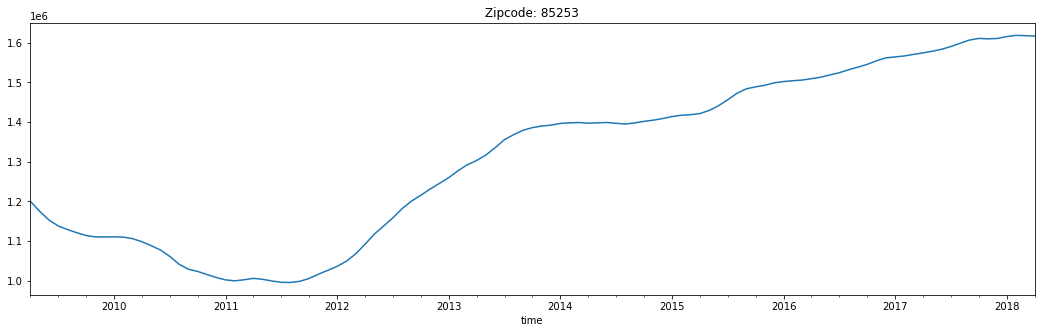

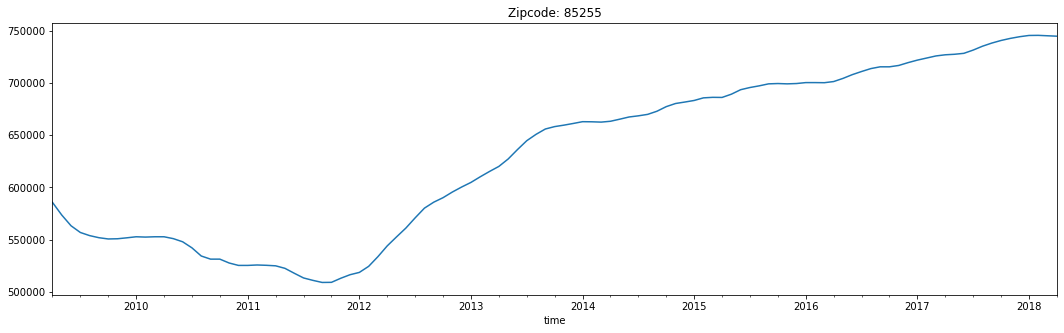

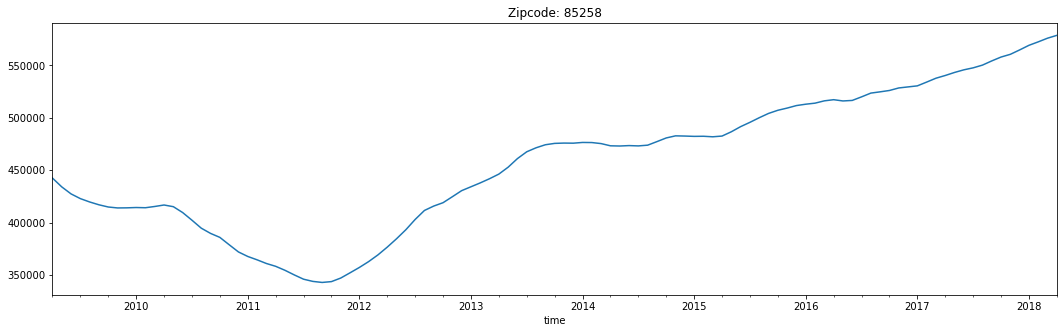

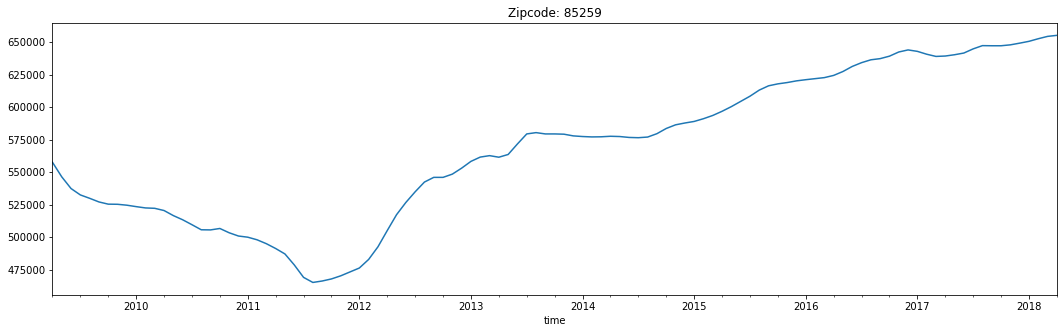

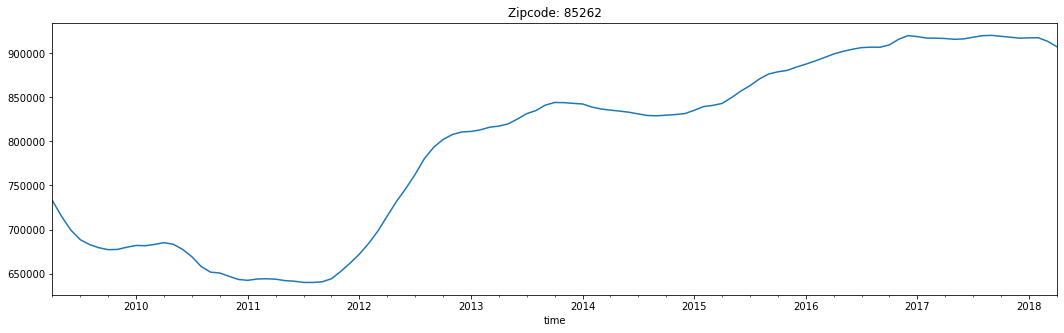

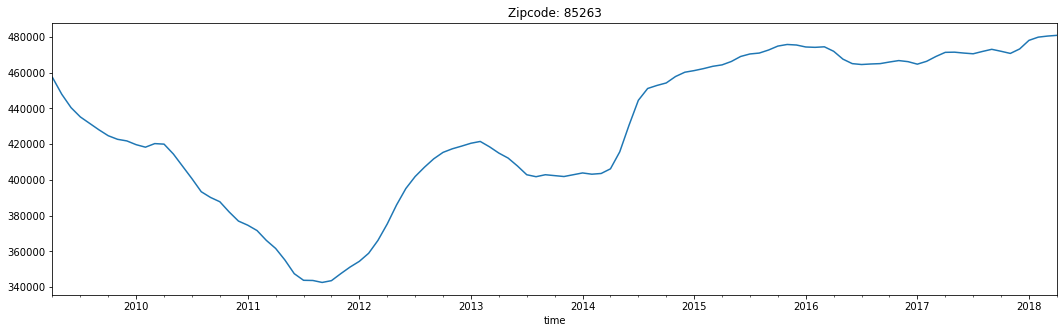

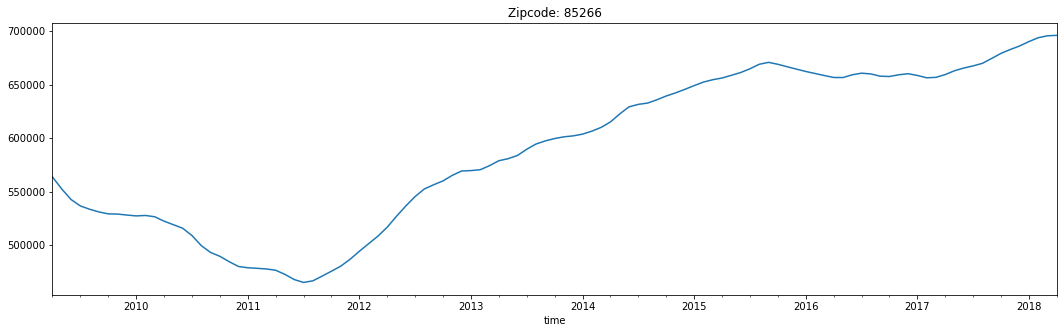

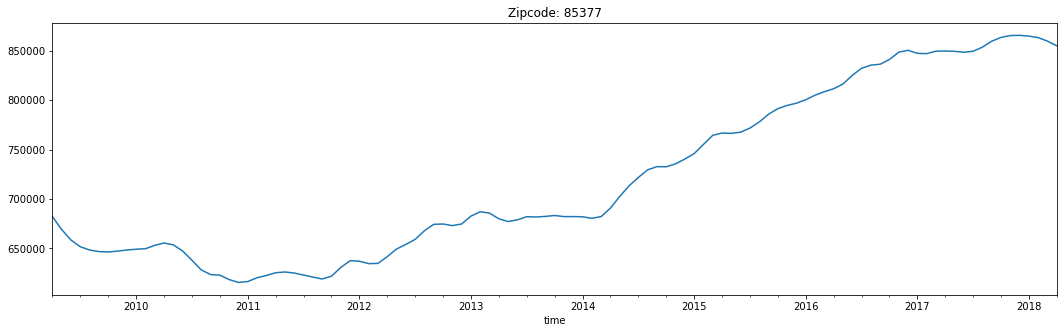

In [19]:
copy = resampled.reset_index()
for z in copy.zipcode.unique():
    plot_zip(z,'value')

In [20]:
for z in copy.zipcode.unique():
    print("zipcode: "+ str(z))
    print(stationarity_check(resampled.loc[z,'value']))
    print()

zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
None

zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -0.960562
p-value                         0.767376
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
None

zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -1.355085
p-value                          0.603610
#Lags Used                       8.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)    

NOT Stationary

### Looking at Growth Stationary

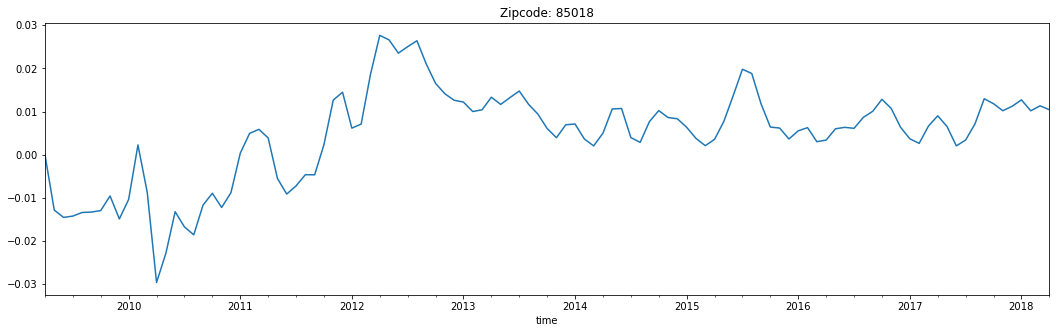

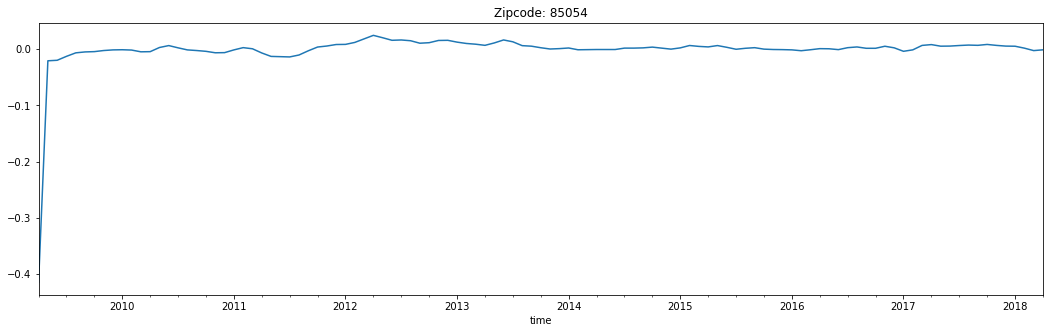

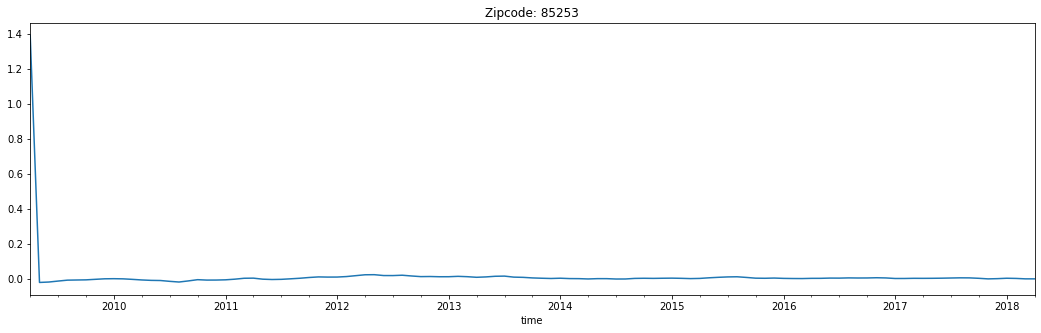

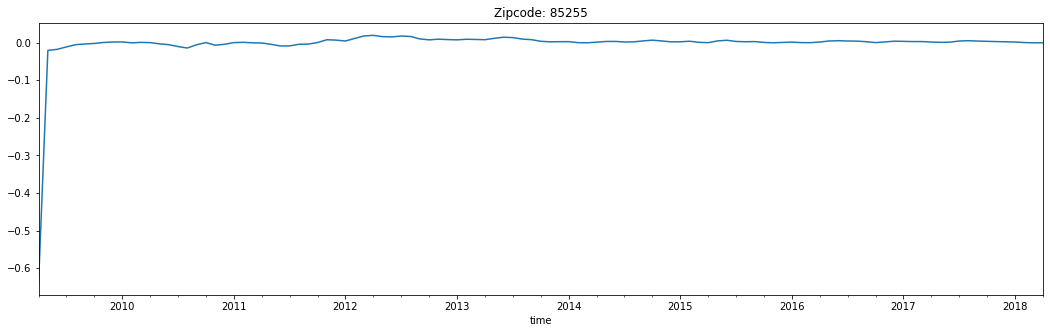

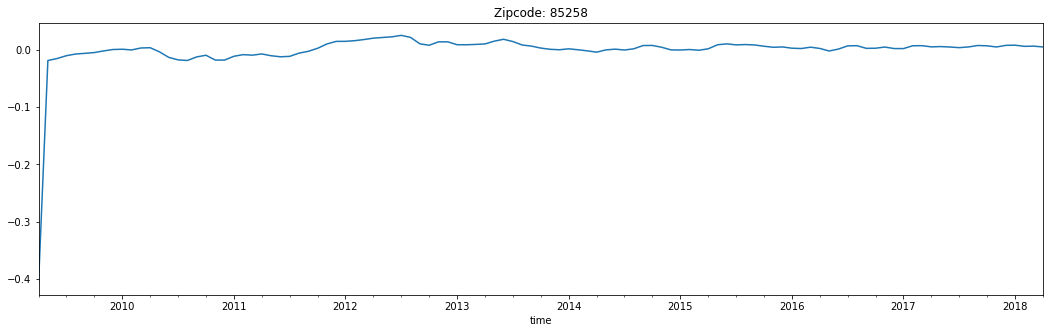

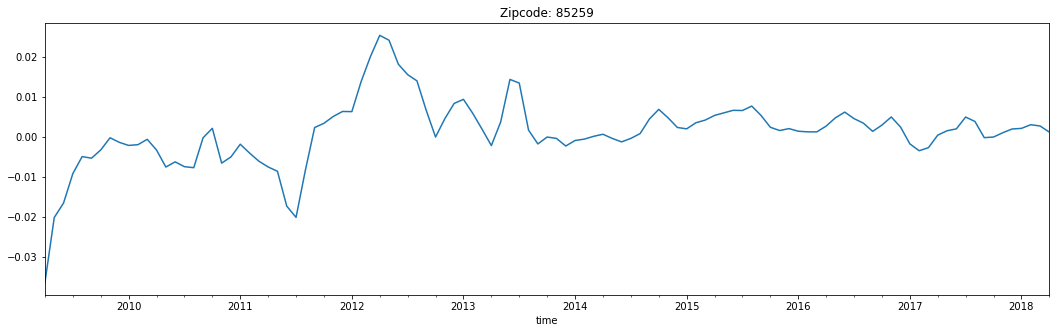

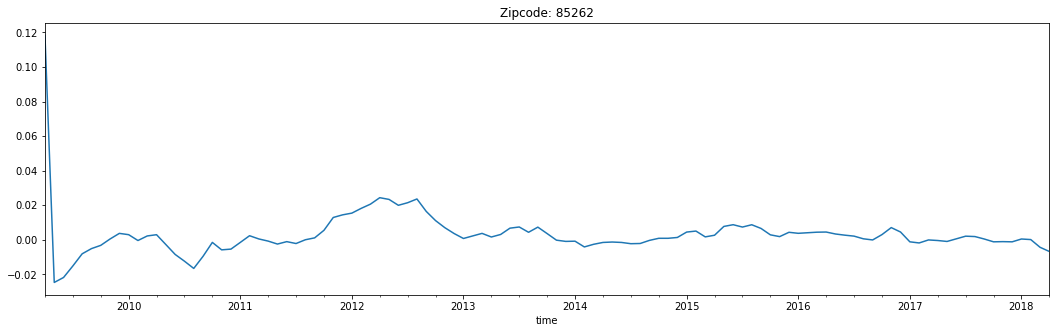

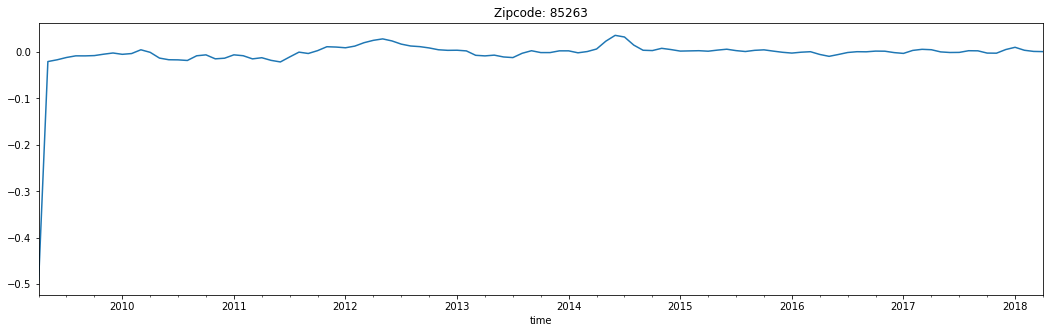

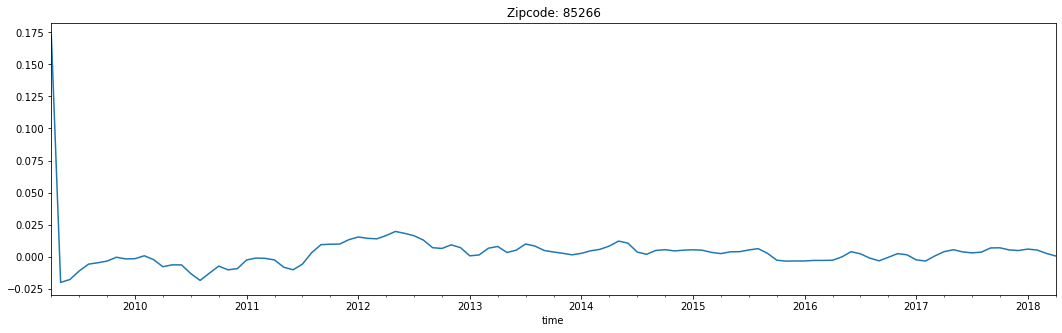

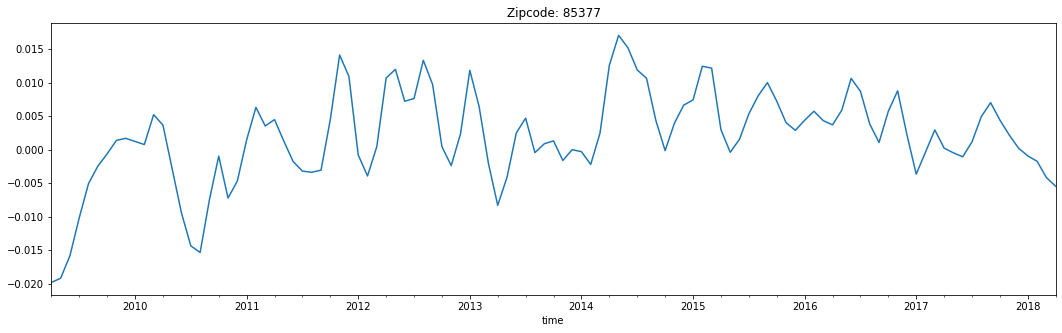

In [21]:
for z in copy.zipcode.unique():
    plot_zip(z,'growth')

In [22]:
for z in copy.zipcode.unique():
    print("Monthly Growth For Zipcode: "+ str(z))
    stationarity_check(resampled.loc[z,'growth'])
    print()

Monthly Growth For Zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

Monthly Growth For Zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -2.763005
p-value                         0.063756
#Lags Used                     11.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64

Monthly Growth For Zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -2.106619
p-value                          0.241861
#Lags Used                       7.000000
Number of Observations Used    101.000000
Critical Value (1%)      

Not Stationary Either

In [23]:
resampled = resampled.reset_index()
resampled['log_value'] = resampled['value'].apply(lambda x: np.log(x))
resampled['log_growth'] = resampled['growth'].apply(lambda x: np.log(x))
resampled = resampled.set_index(['zipcode','time'])
resampled

growth     value  log_value  log_growth
zipcode time                                                 
85018   2009-04-01  0.000000  397600.0  12.893202        -inf
        2009-05-01 -0.012827  392500.0  12.880292         NaN
        2009-06-01 -0.014522  386800.0  12.865663         NaN
        2009-07-01 -0.014219  381300.0  12.851342         NaN
        2009-08-01 -0.013375  376200.0  12.837876         NaN
...                      ...       ...        ...         ...
85377   2017-12-01  0.000231  865500.0  13.671063   -8.372514
        2018-01-01 -0.000924  864700.0  13.670138         NaN
        2018-02-01 -0.001735  863200.0  13.668402         NaN
        2018-03-01 -0.004171  859600.0  13.664222         NaN
        2018-04-01 -0.005468  854900.0  13.658740         NaN

[1090 rows x 4 columns]

In [24]:
def plot_and_dickey_fuller(zipcd):
    print('Value Series for Zipcode: ' + str(zipcd))
    print(plot_zip(zipcd,'value'))
    print()
    print('Stationary Check for Value Series for Zipcode: '+ str(zipcd))
    print()
    print(stationarity_check(resampled.loc[zipcd,'value']))
    print()
    print('Growth Series for Zipcode: ' + str(zipcd))
    print(plot_zip(zipcd,'growth'))
    print()
    print('Stationary Check for Growth Series for Zipcode: '+ str(zipcd))
    print()
    print(stationarity_check(resampled.loc[zipcd,'growth']))
    

Value Series for Zipcode: 85018
None

Stationary Check for Value Series for Zipcode: 85018

Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
None

Growth Series for Zipcode: 85018
None

Stationary Check for Growth Series for Zipcode: 85018

Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
None


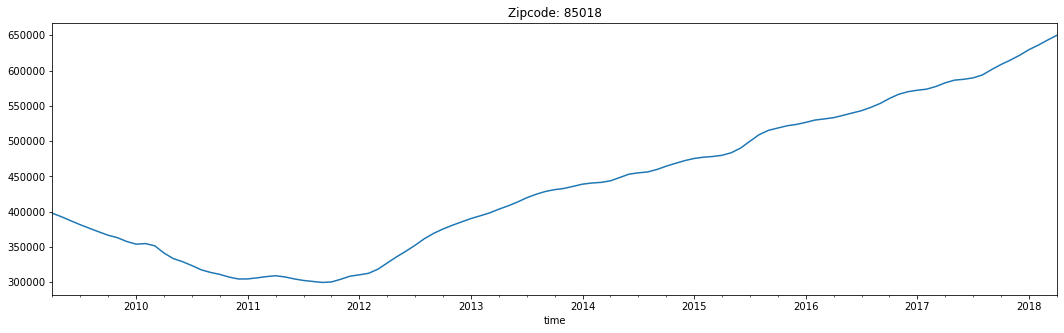

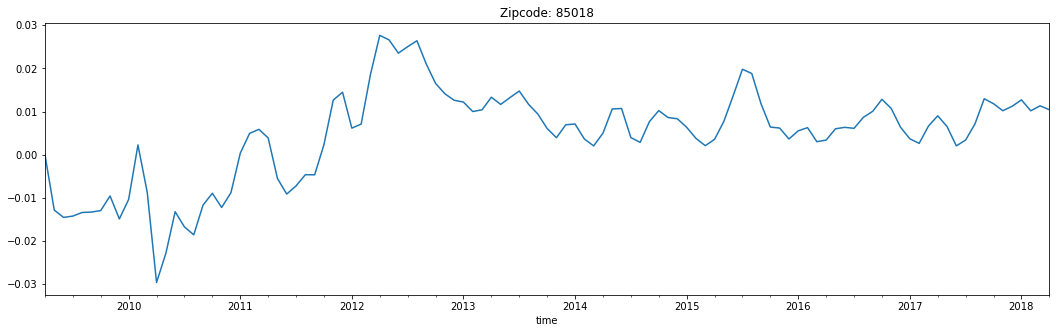

In [25]:
plot_and_dickey_fuller(85018)

In [26]:
# def get_zip(zipcode):
# #     top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
# #     (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
# #                              (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
# #                              (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
# #                              (Phoenix_data['Zipcode'] == 85054)]
# #     zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
# #     #zip_zipcode.drop(['index'],axis=1,inplace=True)
# #     zip_zipcode.reset_index(inplace=True)
    
# #     # shift by one period (month)
# #     resampled_shift_1 = zip_zipcode[['value']].shift(1)
# #     resampled_shift_1.bfill(inplace=True)

# # # reset the indexes to perform calculation of growth
# #     top_10_zips_phx = zip_zipcode.reset_index()
# #     resampled_shift_1 = resampled_shift_1.reset_index()

# # # Growth Calculation
# #     zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])

# # # set the index back to zipcode and time multi-index
# #     zip_zipcode.set_index(['time'],inplace=True)
    
# #     zip_zipcode.drop('Zipcode',axis=1,inplace=True)

#     data = resampled.reset_index()
    
#     print(f'The stationarity check for zipcode:{zipcode}, before adjustments:{stationarity_check(data.growth)}')
    
#     #Original Plot
#     fig, ax = plt.subplots()
#     ax.plot(data.growth)
#     ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
#     #log values and dropna
#     log_zipcode= np.log(data.growth)
#     log_zipcode.dropna(inplace=True)
    
#     # get roll mean and subtract
#     roll_mean = log_zipcode.rolling(window=1,center=False).mean()
#     data_minus_roll_mean = log_zipcode-roll_mean
    
#     #Drop missing values
#     data_minus_roll_mean.dropna(inplace=True)
    
#     #Plot the data minus roll mean
#     #data_minus_roll_mean.plot(figsize=(10,6));
#     fig, ax = plt.subplots()
#     ax.plot(data_minus_roll_mean)
#     ax.set_title(f"Final Zipcode Plot for {zipcode}");

#     print(f'The stationarity check for zipcode:{zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')

In [27]:
# for target choose either 'growth' or 'value' whichever you want to see the series for.
def get_zip(zipcode,target):
    ts = resampled.loc[zipcode,target]
    
    print(f'The stationarity check for zipcode:{zipcode}, before adjustments')
    print()
    print(stationarity_check(ts))
    print()
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(ts)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #diff and dropna
    ts_diff = ts.diff(3)
    ts_diff.dropna(inplace=True)
    
    fig, ax = plt.subplots()
    ax.plot(ts_diff)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode:{zipcode}, after adjustments:')
    print()
    print(stationarity_check(ts_diff))
    

In [28]:
zipcodes = list(resampled.reset_index().zipcode.unique())
zipcodes

[85018, 85054, 85253, 85255, 85258, 85259, 85262, 85263, 85266, 85377]

The stationarity check for zipcode:85018, before adjustments

Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
None

The stationarity check for zipcode:85018, after adjustments:

Results of Dickey-Fuller Test: 

Test Statistic                 -4.784243
p-value                         0.000058
#Lags Used                      6.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64
None


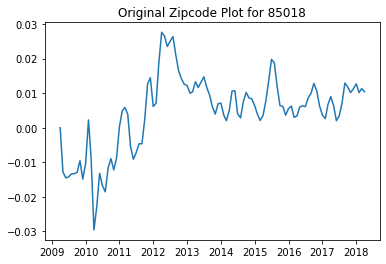

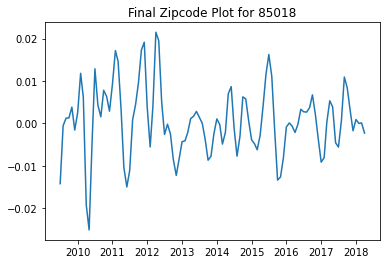

In [29]:
get_zip(85018,'growth')

The stationarity check for zipcode:85018, before adjustments

Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
None

The stationarity check for zipcode:85018, after adjustments:

Results of Dickey-Fuller Test: 

Test Statistic                 -4.784243
p-value                         0.000058
#Lags Used                      6.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64
None
None
The stationarity check for zipcode:85054, before adjustments

Results of Dickey-Fuller Test: 

Test Statistic                 -2.763005
p-value                         0.063756
#Lags Used   

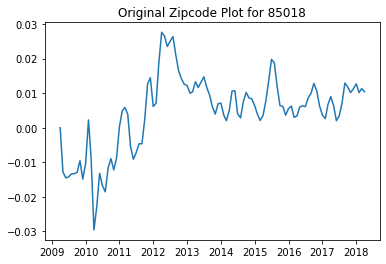

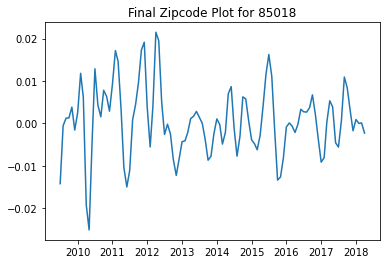

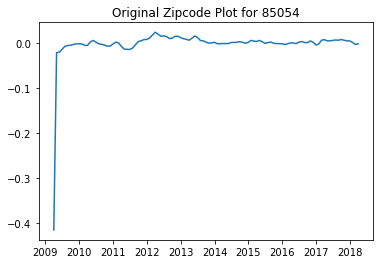

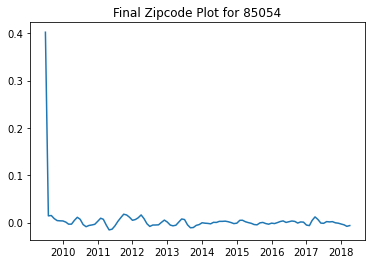

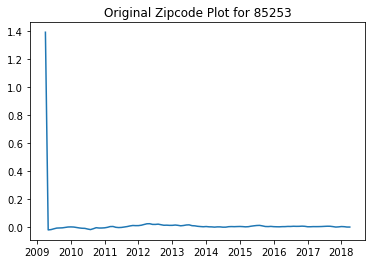

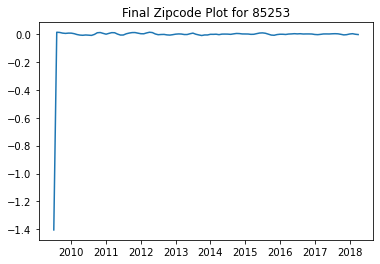

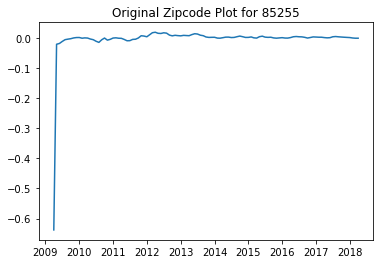

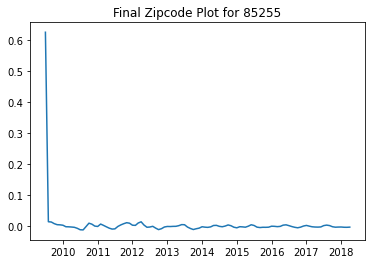

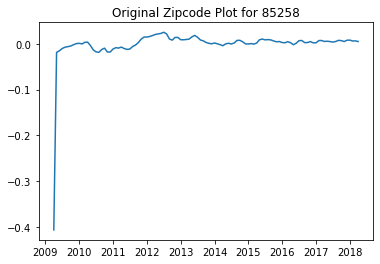

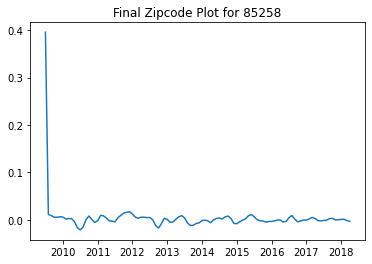

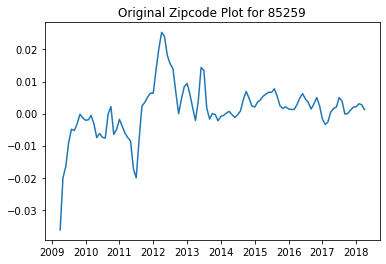

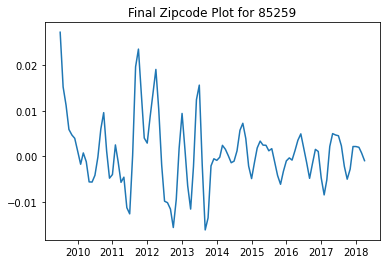

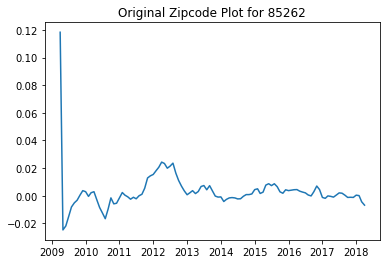

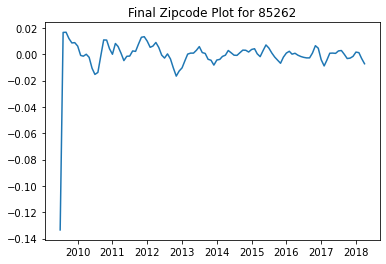

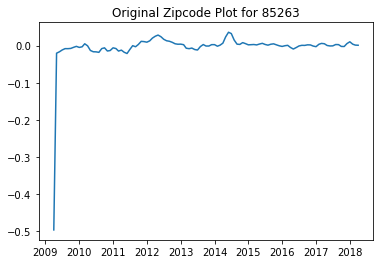

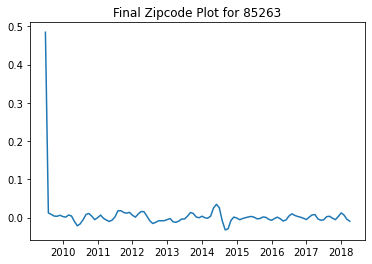

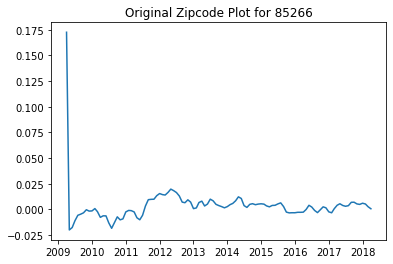

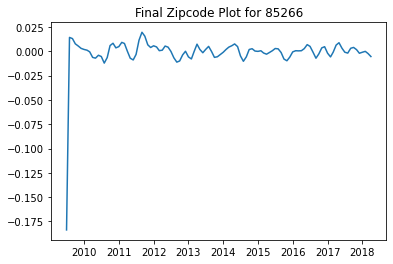

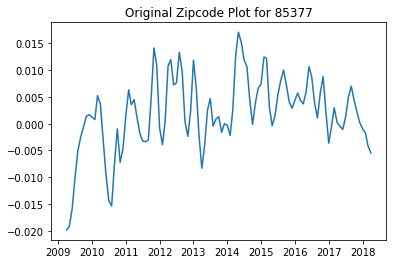

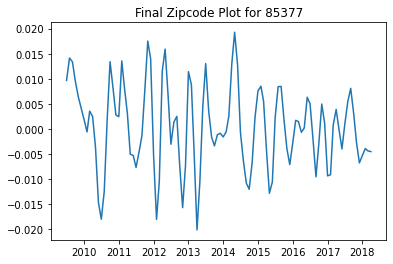

In [30]:
for z in zipcodes:
    print(get_zip(z,'growth'))    

# Modeling

In [31]:
ts = resampled.loc[85018,['growth']]
ts

,growth
time,
2009-04-01,0.000000
2009-05-01,-0.012827
2009-06-01,-0.014522
2009-07-01,-0.014219
2009-08-01,-0.013375
...,...
2017-12-01,0.011223
2018-01-01,0.012707
2018-02-01,0.010165


In [32]:
cutoff = round(ts.shape[0]*0.8)
cutoff

87

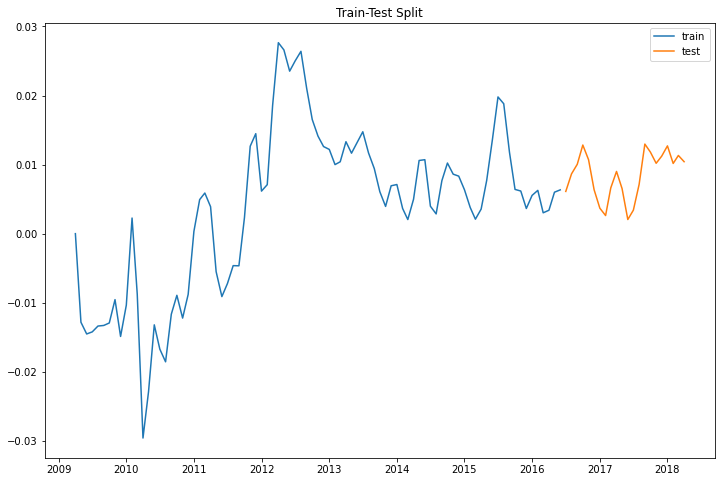

In [33]:
train = ts[:cutoff]

test = ts[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [34]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [45 46 47 48 49 50 51 52 53 54 55 56 57 58]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58] [59 60 61 62 63 64 65 66 67 68 69 70 71 72]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72] [73 74 75 76 77 78 79 80 81 82 83 84 85 86]


In [35]:
baseline = train.shift(1)
baseline

,growth
time,
2009-04-01,NaN
2009-05-01,0.000000
2009-06-01,-0.012827
2009-07-01,-0.014522
2009-08-01,-0.014219
...,...
2016-02-01,0.005539
2016-03-01,0.006268
2016-04-01,0.003020


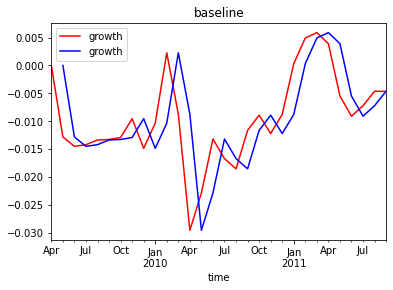

In [36]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [37]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

0.005191819026814273

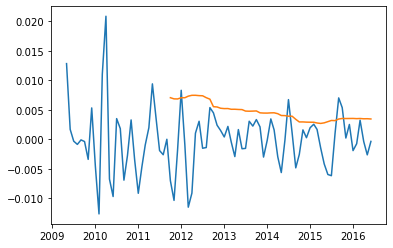

In [38]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

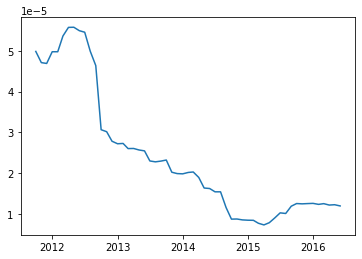

In [39]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

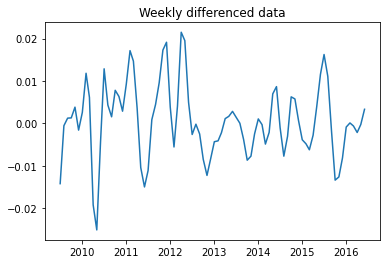

In [40]:
fig, ax = plt.subplots()
ax.plot(train.diff(3).dropna())
ax.set_title('Weekly differenced data');

In [41]:
p_val = adfuller(train.diff(3)[1:].dropna())[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0009386804360347777,
 so we can safely assume that the differenced data is stationary.


In [42]:
ar_1 = ARIMA(train, order=(0, 3, 1),).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2009-04-01    0.000000
2009-05-01    0.000000
2009-06-01   -0.032067
2009-07-01   -0.005086
2009-08-01   -0.007352
                ...   
2016-02-01    0.007603
2016-03-01    0.007143
2016-04-01   -0.000148
2016-05-01    0.003891
2016-06-01    0.008786
Freq: MS, Name: predicted_mean, Length: 87, dtype: float64

In [43]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   87
Model:                 ARIMA(0, 3, 1)   Log Likelihood                 302.203
Date:                Wed, 05 Jan 2022   AIC                           -600.405
Time:                        11:41:18   BIC                           -595.543
Sample:                    04-01-2009   HQIC                          -598.451
                         - 06-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9877      0.327     -3.023      0.003      -1.628      -0.347
sigma2      4.203e-05    1.4e-05      2.993      0.003    1.45e-05    6.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.45
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
train_with_ind = train.reset_index()

In [45]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 3, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.08489179157591284
0.3253627105113007


/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0462910093521914
0.21329782591143695
0.1577085411853522


/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


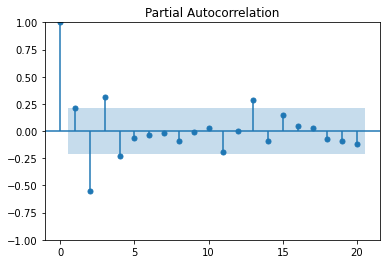

In [46]:
plot_pacf(train.diff().dropna());

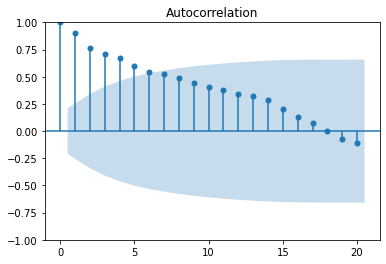

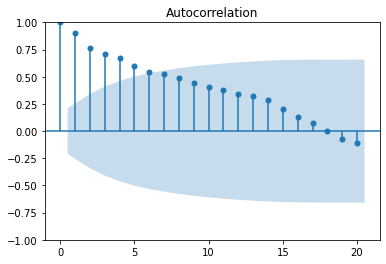

In [47]:
plot_acf(train)

### Trying out Facebook Prophet Forecasting on Zipcode: 85018

In [48]:
import warnings
warnings.simplefilter('ignore')

from fbprophet import Prophet

In [49]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)

In [50]:
zipcode_85018 = resampled.loc[85253,['growth']]
zipcode_85018.rename(columns={'growth':'y'},inplace=True)
zipcode_85018.index.name = 'ds'
zipcode_85018 = zipcode_85018.reset_index()
zipcode_85018 = zipcode_85018[['ds','y']]
zipcode_85018

,ds,y
0,2009-04-01,1.390880
1,2009-05-01,-0.021071
2,2009-06-01,-0.018717
3,2009-07-01,-0.013178
4,2009-08-01,-0.007995
...,...,...
104,2017-12-01,0.000621
105,2018-01-01,0.002918
106,2018-02-01,0.001919
107,2018-03-01,-0.000494


In [51]:
model.fit(zipcode_85018)

Trying to forecast home value for the next 60 months (or 5 years)

In [52]:
future = model.make_future_dataframe(periods=5*12,freq='MS')

In [53]:
forecast = model.predict(future)

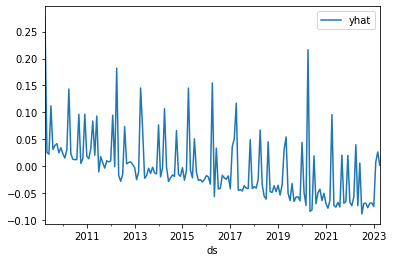

In [54]:
forecast_plot = forecast[['ds','yhat']]
forecast_plot.plot();

(-0.5, 0.5)

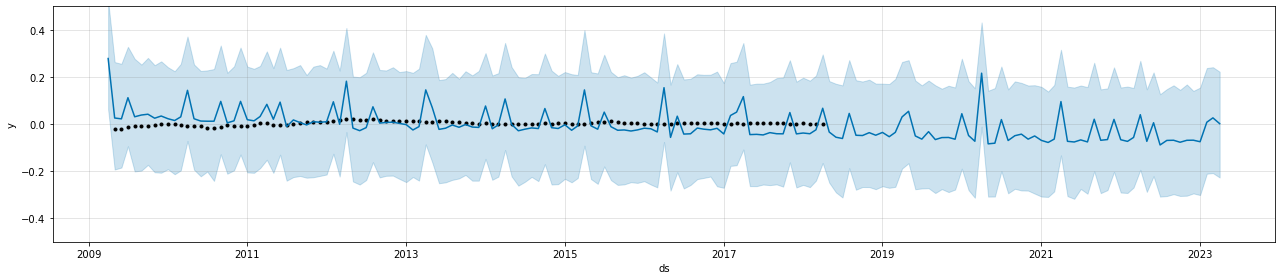

In [62]:
fig, ax = plt.subplots(figsize=(18,4)) 
model.plot(forecast, uncertainty=True,ax = ax)
plt.ylim((-0.5,0.5))

In [56]:
def fb_prophet_model(Zip,target):
    model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)
    ts = resampled.loc[Zip,[target]].reset_index()
    ts.rename(columns={target:'y','time':'ds'},inplace=True)
    ts = zipcode_85018[['ds','y']]
    return model.fit(ts)

In [57]:
def predict(model,k_periods,plot=False):
    future = model.make_future_dataframe(periods=k_periods,freq='MS')
    forecast = model.predict(future)
    if plot == True:
        fig, ax = plt.subplots(figsize=(18,4)) 
        model.plot(forecast, uncertainty=True,ax = ax)
        plt.ylim((-0.5,0.5))
        return forecast
    return forecast    

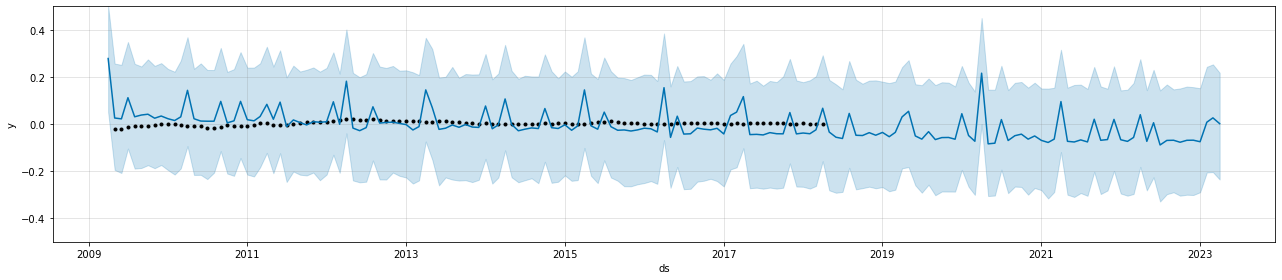

In [60]:
x = fb_prophet_model(85253,'growth')
x_forecast = predict(x,60,True)

In [65]:
x_forecast[['ds','yhat']].tail()

,ds,yhat
164,2022-12-01,-0.068363
165,2023-01-01,-0.074872
166,2023-02-01,0.008010
167,2023-03-01,0.026509
168,2023-04-01,0.001931
